### Steps included in the notebook
1. Load libraries
2. Load and save images for Eagles, Hawks and Parrots from Bing Image Search
3. Remove the invalid images
4. Prepare images for the model
5. Train the CNN model
6. Examine results and use the `ImageClassifierCleaner` library to manually edit wrong labels
7. Tune model into an online application

In [2]:
# 1
# Install fastbook and import libraries
!pip install -Uqq fastbook 
# --use-feature=2020-resolver
import fastbook
fastbook.setup_book()
#import warnings
#warnings.filterwarnings('ignore')


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

voila 0.2.3 requires nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.


In [3]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
path = Path()

In [3]:
# Get the Bing Image Search Key
# This is hardcoded and the keys are different for each user
key1= '24084121de2e4ee7b0e5a6aebf60090b'
key2= 'ece16e06034147cb86bea32ed19eb2c4'
key = os.environ.get('AZURE_SEARCH_KEY', key1)

In [4]:
# Test the key
results = search_images_bing(key, 'eagle')
ims = results.attrgot('content_url')
len(ims)

150

We succesfully downloaded 150 images with the label "eagle". Our image search works. Let's get images for eagles, hawks and parrots. As a next step we create a directory whereby the images of the birds are aved in a folder with the label's name

In [5]:
# 2
# Load and save images for Eagles, Hawks and Parrots from Bing Image Search
bird_types = 'eagle','hawk','parrot'
path = Path('birds')

if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [6]:
# 3
# Remove invalid pictures
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called DataLoaders.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

In [7]:
# 4
# Prepare images for the model
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```
The independent variables are images, and the dependent variables are the categories (type of bird) for each image.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

We define the train/validation set by assigning a random 20% of the data as the validation set

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```
The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bird images into folders based on the type of bird, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. 

In [8]:
# We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:
dls = birds.dataloaders(path)

When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

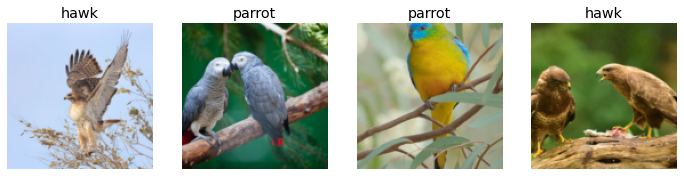

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

We don't have a lot of data for our problem (150 pictures for each bird at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms to produce more images using data augmentation

In [10]:
# Data augmentation
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

Create the `Learner` using a pretrained image classifier and fine tune it for the bird classification problem

In [11]:
# 5
# Train the model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.644672,0.220627,0.080460,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.563101,0.204216,0.068966,00:12
1,0.419111,0.199246,0.080460,00:11
2,0.338575,0.210674,0.080460,00:12
3,0.294791,0.214664,0.080460,00:12


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:7

Examine the results by looking at the confusion matrix

Use the `ClassificationInterpratation` library of fastai to examine the confusion matrix

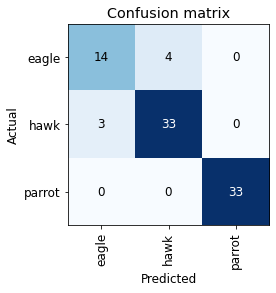

In [12]:
# 6
# Examine the results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Most of the mistakes have been made for eagles and hawks and there are two cases that the model predicted parrot incorrectly. Let's dive in the data and see what causes the model to make these mistakes

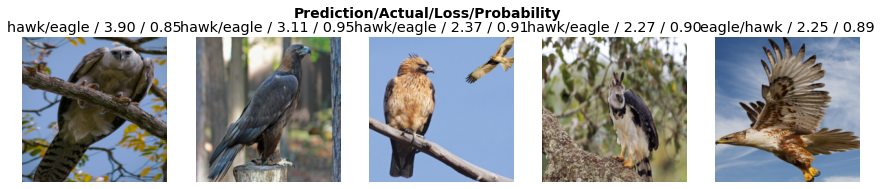

In [13]:
# Look at the five top losses cases
interp.plot_top_losses(5, nrows=1)

In [14]:
# Clean data
# After you have made changes to the labels, you need to runner one or both of the following cells
# hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
# Only run when you need to update the data
# Deleting images altogether
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [ ]:
# Only run when you need to update the data
# Moving images to different directories
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Turn the model into an online app

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call export, fastai will save a file called "export.pkl":

In [18]:
# 7
# Save the model
learn.export()

In [19]:
# Check that the file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [20]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
#learn_inf.predict('images/eagle.jpg')

In [22]:
learn_inf.dls.vocab

(#3) ['eagle','hawk','parrot']

In [35]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learn_inf.predict(img)

In [39]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: hawk; Probability: 1.0000')

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [1]:
#hide_output
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

NameError: name 'VBox' is not defined

In [44]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.0.18 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
      voila 0.2.3 OK
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
